In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import librosa
import torch
import torchaudio.functional as F
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Audio, display


parent = os.path.abspath(os.path.join('..'))
sys.path.append(parent)

from augmentations.augmentations import *
import augmentations.augmentations.misc as misc

from data import AudioSetViews

In [2]:
def audio_to_melspectrogram(audio, sampling_rate, hop_length=256, n_fft=2048):
    spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sampling_rate, hop_length=hop_length, n_fft=n_fft
    )
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(spectrogram, sampling_rate, title="log-frequency power spectrogram"):
    librosa.display.specshow(spectrogram, x_axis="time", y_axis="mel", sr=sampling_rate)
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()


def show_signal(audio):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()


def show_and_play_signal(audio, sample_rate):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()
    display(Audio(audio, rate=sample_rate))


def read_as_melspectrogram(file_path):
    audio, sampling_rate = misc.load_audio(file_path)
    spectrogram = audio_to_melspectrogram(audio, sampling_rate)
    return spectrogram

In [3]:
sample_rate = 8000
batch_size = 32

transforms = Compose(
    [
        RandomCropExpand(8 * sample_rate, 10 * sample_rate, pad_type="zero"),
        RandomApply(PolarityInversion(), 0.5),
        Noise(min_snr=0.1, max_snr=0.3),
        RandomGain(),
        RandomApply(HighLowPass(sample_rate), p=0.5),
        RandomApply(PitchShift(10 * sample_rate, sample_rate), p=0.5),
        RandomApply(RandomRIR(), p=0.5),
        RandomApply(RandomEncoder(sample_rate=sample_rate), p=0.5),
    ]
)

dataset = AudioSetViews(
    df_path="/storage13/datasets/audioset/audios/balanced_train/records-hot1.pkl",
    transforms=transforms,
    sample_rate=sample_rate,
    num_views=2,
    num_repeat=1,
)
loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=2,
    shuffle=False,
)

In [4]:
batch = next(iter(loader))
audios = torch.cat(batch["audio"], axis=0)

[W encode_process.cpp:170] Warning: "vorbis" encoder is selected. Enabling '-strict experimental'. If this is not desired, please provide "strict" encoder option with desired value. (function operator())
[W encode_process.cpp:170] Warning: "vorbis" encoder is selected. Enabling '-strict experimental'. If this is not desired, please provide "strict" encoder option with desired value. (function operator())


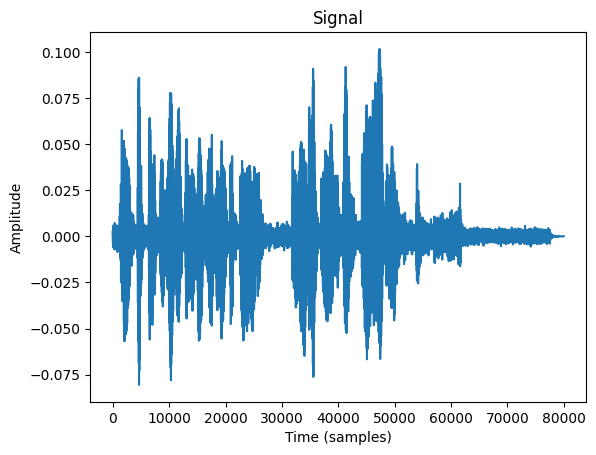

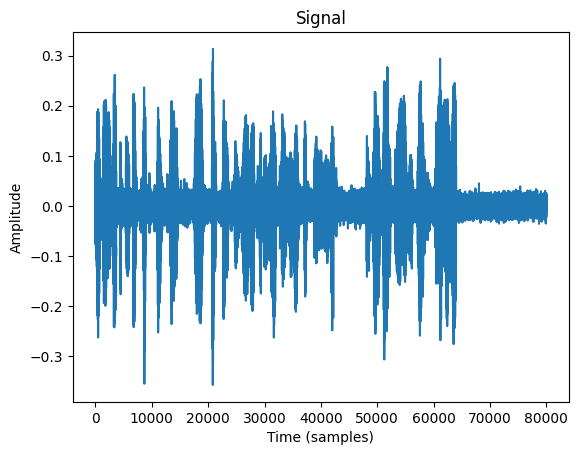

In [5]:
index = 0
audio = audios[index]
show_and_play_signal(audio, sample_rate)
audio = audios[index + batch_size]
show_and_play_signal(audio, sample_rate)